In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Подготовим данные

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor()])


batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

im size =  torch.Size([128, 3, 32, 32])


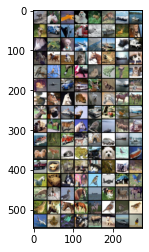

deer  dog   plane dog   deer  deer  ship  ship  bird  truck plane truck deer  ship  deer  dog   cat   frog  dog   ship  plane ship  cat   truck horse horse horse cat   horse bird  ship  cat   bird  bird  bird  cat   dog   frog  bird  cat   dog   plane car   ship  deer  dog   ship  horse cat   horse horse frog  dog   horse horse horse deer  dog   ship  deer  car   truck deer  plane truck horse horse horse bird  ship  deer  truck ship  bird  truck deer  cat   car   ship  ship  dog   horse car   frog  truck dog   bird  ship  truck car   horse horse cat   bird  truck deer  horse car   dog   dog   bird  plane car   bird  deer  dog   bird  horse ship  cat   deer  horse bird  horse horse horse horse bird  bird  bird  plane frog  bird  cat   deer  dog   car   bird 


In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('im size = ', images.size())
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Напишем автокодировщик. Будем использовать автокодировщик, основанный на свертках. Автокодировщик для cifar10 можно построить чисто на линейных слоях, но качество работы у него будет заметно хуже (протестировано).

In [9]:
class AE(nn.Module):
    def __init__(self, input_channel, hidden_channel = 18, latent_dim = 30):
        super(AE, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size=3, padding=1, stride=2), # 16x16
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, 2*hidden_channel, kernel_size=3, padding=1, stride=2), # 8x8
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1, stride=2), # 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2*16*hidden_channel, latent_dim)
        )
        
        self.proj = nn.Sequential(
            nn.Linear(latent_dim, 2*16*hidden_channel),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*hidden_channel, hidden_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channel, input_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 32x32
            nn.Tanh()
        )

                
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.proj(encoded)
        decoded = decoded.reshape(decoded.shape[0], -1, 4, 4)
        decoded = self.decoder(decoded)
        return [encoded, decoded]

Класс для обучения, вывода графиков и оперирования сетью.

In [10]:
class trainer():
    def __init__(self, net, dataloader_train, dataloader_test):
        self.net = net
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), weight_decay=1e-5)
        
    def train(self, epochs):
        timer = epochs//10 + 1
        L = []
        for epoch in range(epochs):
            L_mean = []
            for train_feat, train_lab in self.dataloader_train:
                train_feat = train_feat.cuda()
                _, reconstructed = self.net(train_feat)

                loss = self.loss_function(reconstructed, train_feat)
                L.append(loss.detach().cpu())
                L_mean.append(loss.detach().cpu())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
            print('loss = ', np.mean(L_mean))
            
        self.imshow(train_feat.detach().cpu())
        self.imshow(reconstructed.detach().cpu())
                    
        plt.plot(L)
        plt.show()
        
    def test(self):
        L = []
        for test_feat, test_lab in self.dataloader_test:
            test_feat = test_feat.cuda()
            _, reconstructed = self.net(test_feat)
            loss = self.loss_function(reconstructed, test_feat)
            L.append(loss.detach().cpu())
        self.imshow(test_feat.detach().cpu())
        self.imshow(reconstructed.detach().cpu())
        print(np.mean(L))

        
    def imshow(self, img):
        img = torchvision.utils.make_grid(img)
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

Выберем скрытое состояние размерности 144. 

Очевидно, что в латентное пространство размерности 32 (т.е. <4 пикселей с учетом бинарной цветвоой палитры) сколь нибудь информативный набор признаков уместить невозможно. Нам нужно как минимум сохранить цветовую палитру и 4 пикселя, это 4 * 4 * 3 = 64. Это минимальный размер латентного пространства. 

При этом очевидно, при повышении размерности латентного пространства качество реконструкции будет расти. Взятая величина эквивалентна тому, что мы разбили изображение на ~7 пикселей с тремя цветовыми каналами. 

В идеале нужно провести тестирование на малом наборе данных различных значений размерности латентного пространства и построить по данным график зависимости метрики от числа параметров. Тогда начиная с определенной размерности латентного пространства его увеличение не будет значительно сказываться на метрике.

In [11]:
net = AE(input_channel=3, hidden_channel = 50, latent_dim = 144).cuda()

In [12]:
tr = trainer(net, trainloader, testloader)

loss =  0.03076644
loss =  0.013548327
loss =  0.010963861
loss =  0.010120672
loss =  0.009527912
loss =  0.009147715
loss =  0.008446539
loss =  0.00803021
loss =  0.007476349
loss =  0.0070615057


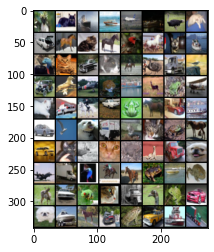

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


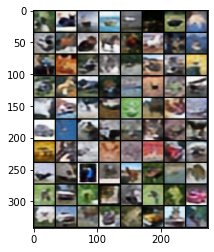

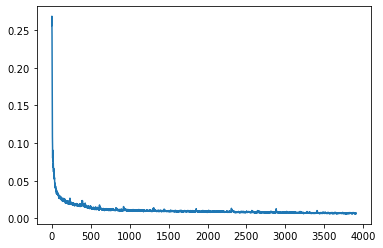

In [13]:
tr.train(10)

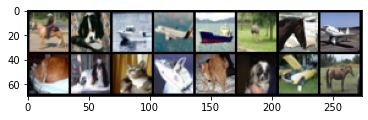

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


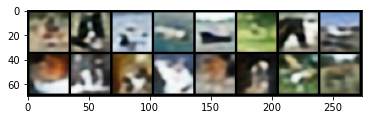

0.006766511


In [14]:
tr.test()

На самом деле лучше себя показал в тестах автокодировщик на основе обычной сверточной сети небольшого размера (<3 слоев в кодере и декодере) типа 

encoder: conv -> batchnorm - > ReLu -> MaxPool, 

decoder: ConvTranspose2d -> batchnorm -> ReLU

(на самом деле batchnorm не показал никакого значимого эффекта).

Классификация латентных состояний, к сожалению, показала себя значительно хуже ожидаемого. Во всяком случае при использовании относительно простого классификатора.

In [15]:
classifier = nn.Sequential(
                nn.Linear(144, 60),
                nn.BatchNorm1d(60),
                nn.ReLU(),
                nn.Linear(60, 60),
                nn.BatchNorm1d(60),
                nn.ReLU(),
                nn.Linear(60, 10)
                )

In [16]:
class trainer2():
    def __init__(self, net_trained, net_class, dataloader_train, dataloader_test):
        self.net_trained = net_trained
        self.net_class = net_class
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.net_class.parameters(), lr=0.01, weight_decay=0)
        
    def train(self, epochs):
        timer = epochs//10 + 1
        L = []
        for epoch in range(epochs):
            L1 = []
            for train_feat, train_lab in self.dataloader_train:
                train_lab = train_lab.cuda()
                train_feat = train_feat.cuda()
                endoded, _ = self.net_trained(train_feat)
                
                label = self.net_class(endoded)
                
                loss = self.loss_function(label, train_lab)
                L1.append(loss.detach().cpu())

                    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            L.append(np.mean(L1))
            print('loss = ', np.mean(L1))
                
        plt.plot(L)
        plt.show()
        
    def test(self):
        accuracy = 0.0
        total = 0.0

        for test_feat, test_lab in self.dataloader_test:
                test_lab = test_lab.cuda()
                test_feat = test_feat.cuda()
                endoded, _ = self.net_trained(test_feat)
                
                label = self.net_class(endoded)
                
                _, predicted = torch.max(label.data, 1)
                total += test_lab.size(0)
                accuracy += (predicted == test_lab).sum().item()

                print('true lab = ', test_lab)
                print('predicted lab = ', predicted)
        accuracy = (100 * accuracy / total)
        print('full acc = ', accuracy)

In [17]:
net_class = classifier.cuda()

In [18]:
tr2 = trainer2(net, net_class, trainloader, testloader)

loss =  1.598933
loss =  1.4257842
loss =  1.3628026
loss =  1.3255284
loss =  1.2963246
loss =  1.2742321
loss =  1.2555453
loss =  1.2436196
loss =  1.2272638
loss =  1.2204351
loss =  1.2097619
loss =  1.2024678
loss =  1.1935605
loss =  1.1911983
loss =  1.1845257
loss =  1.179357
loss =  1.1750894
loss =  1.1698436
loss =  1.1643037
loss =  1.1627634
loss =  1.1571126
loss =  1.1526432
loss =  1.1515131
loss =  1.1494983
loss =  1.1429468
loss =  1.1423562
loss =  1.1380142
loss =  1.1375778
loss =  1.1360294
loss =  1.130115
loss =  1.1303985
loss =  1.1285433
loss =  1.1224821
loss =  1.1236433
loss =  1.1187526
loss =  1.1171386
loss =  1.1139723
loss =  1.1140914
loss =  1.1179788
loss =  1.112333
loss =  1.1099039
loss =  1.1089897
loss =  1.1087261
loss =  1.1068206
loss =  1.1065186
loss =  1.10551
loss =  1.103673
loss =  1.1038433
loss =  1.1007695
loss =  1.0998026
loss =  1.0982785
loss =  1.0962104
loss =  1.0957716
loss =  1.0967841
loss =  1.0927321
loss =  1.0938717

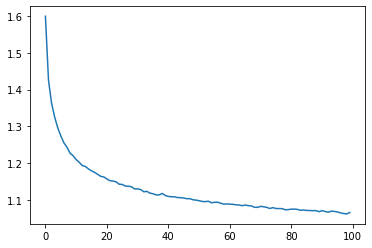

In [19]:
tr2.train(100)

In [20]:
tr2.test()

true lab =  tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
predicted lab =  tensor([3, 9, 8, 0, 6, 6, 3, 6, 5, 1, 0, 1, 5, 7, 9, 8, 5, 7, 8, 5, 0, 0, 0, 9,
        4, 2, 4, 7, 9, 6, 3, 4, 4, 5, 9, 9, 7, 1, 0, 6, 0, 6, 3, 4, 0, 9, 3, 3,
        4, 6, 9, 8, 6, 3, 8, 8, 7, 6, 3, 7, 7, 3, 2, 9, 6, 2, 1, 2, 5, 7, 6, 6,
        8, 8, 0, 4, 9, 4, 3, 0, 8, 1, 1, 5, 2, 7, 2, 2, 8, 9, 0, 4, 0, 6, 4, 5,
        6, 0, 3, 7, 5, 7, 6, 3, 1, 1, 4, 6, 9, 5, 4, 0, 2, 2, 1, 3, 0, 9, 3, 7,
        8, 5, 2, 2, 0, 6, 0, 5], device='cuda:0')
true lab =  tensor([5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 

true lab =  tensor([3, 8, 9, 5, 8, 9, 8, 9, 1, 6, 5, 9, 4, 4, 8, 0, 7, 2, 9, 7, 4, 1, 6, 4,
        4, 9, 1, 2, 5, 6, 0, 8, 6, 1, 9, 4, 5, 9, 5, 0, 7, 2, 0, 0, 4, 2, 6, 6,
        5, 5, 2, 8, 1, 7, 3, 1, 4, 5, 6, 5, 1, 4, 7, 0, 9, 4, 3, 8, 2, 8, 4, 7,
        2, 3, 1, 5, 2, 9, 8, 9, 7, 9, 5, 1, 4, 0, 8, 2, 3, 8, 9, 1, 1, 3, 2, 4,
        9, 3, 1, 7, 4, 6, 2, 8, 9, 5, 3, 9, 5, 5, 6, 7, 2, 4, 6, 3, 1, 0, 7, 2,
        5, 4, 7, 6, 1, 1, 9, 8], device='cuda:0')
predicted lab =  tensor([5, 8, 9, 7, 5, 1, 8, 9, 1, 6, 5, 9, 3, 5, 4, 0, 3, 0, 9, 7, 3, 1, 6, 2,
        2, 9, 3, 0, 4, 6, 8, 8, 6, 1, 9, 3, 5, 9, 3, 2, 2, 3, 9, 8, 9, 4, 6, 6,
        3, 5, 5, 8, 1, 3, 3, 1, 4, 6, 6, 5, 1, 4, 6, 8, 9, 2, 2, 8, 4, 8, 6, 7,
        7, 4, 1, 5, 5, 9, 1, 9, 7, 9, 5, 1, 4, 0, 8, 2, 3, 8, 9, 0, 1, 4, 0, 4,
        1, 4, 9, 4, 5, 6, 0, 4, 6, 5, 3, 9, 3, 6, 6, 4, 2, 2, 5, 3, 1, 0, 7, 0,
        5, 5, 7, 4, 1, 1, 7, 8], device='cuda:0')
true lab =  tensor([1, 0, 1, 3, 1, 1, 1, 7, 3, 9, 6, 8, 4, 6, 8, 4, 9, 

predicted lab =  tensor([1, 5, 1, 6, 6, 0, 8, 9, 0, 9, 7, 2, 3, 3, 7, 8, 4, 8, 4, 8, 6, 5, 0, 2,
        7, 7, 2, 9, 0, 7, 4, 6, 7, 9, 8, 3, 6, 8, 5, 0, 0, 3, 0, 5, 5, 6, 6, 6,
        6, 9, 1, 0, 6, 5, 9, 7, 1, 3, 3, 2, 2, 4, 7, 5, 4, 3, 8, 8, 8, 8, 3, 3,
        1, 6, 2, 4, 8, 9, 1, 8, 1, 1, 0, 8, 9, 9, 8, 7, 2, 0, 6, 3, 4, 1, 6, 2,
        6, 9, 5, 7, 4, 3, 6, 1, 7, 2, 4, 6, 5, 9, 8, 3, 0, 3, 4, 7, 5, 8, 3, 4,
        2, 4, 5, 6, 5, 6, 6, 6], device='cuda:0')
true lab =  tensor([5, 6, 5, 4, 5, 8, 8, 0, 9, 7, 9, 0, 6, 9, 6, 1, 4, 7, 9, 0, 3, 5, 4, 7,
        6, 9, 8, 2, 3, 9, 3, 3, 7, 8, 3, 5, 5, 9, 6, 1, 4, 7, 4, 8, 7, 7, 1, 3,
        0, 3, 2, 5, 4, 9, 3, 5, 4, 7, 0, 3, 7, 0, 2, 1, 5, 8, 7, 3, 5, 7, 8, 5,
        7, 8, 1, 5, 4, 7, 0, 8, 3, 2, 9, 7, 4, 1, 6, 5, 9, 8, 5, 5, 4, 1, 0, 9,
        4, 4, 3, 0, 4, 8, 0, 8, 2, 9, 5, 9, 7, 4, 6, 7, 9, 2, 9, 3, 7, 7, 8, 2,
        2, 0, 2, 5, 3, 6, 4, 7], device='cuda:0')
predicted lab =  tensor([7, 3, 3, 6, 3, 8, 0, 2, 8, 5, 9, 9, 6, 9, 6, 1

true lab =  tensor([1, 7, 7, 2, 3, 3, 5, 1, 7, 6, 8, 4, 4, 5, 7, 3, 4, 7, 7, 3, 6, 0, 7, 2,
        6, 7, 4, 1, 8, 0, 2, 2, 1, 5, 4, 0, 9, 3, 4, 4, 2, 3, 8, 5, 0, 0, 4, 6,
        3, 9, 2, 0, 5, 7, 5, 5, 1, 7, 3, 1, 6, 7, 9, 0, 1, 2, 1, 4, 6, 1, 5, 9,
        5, 0, 4, 9, 4, 9, 7, 1, 6, 8, 0, 6, 5, 0, 8, 1, 7, 5, 6, 9, 3, 2, 3, 9,
        8, 6, 1, 0, 9, 0, 9, 8, 7, 7, 5, 2, 3, 5, 5, 7, 8, 7, 6, 9, 1, 9, 8, 6,
        5, 6, 7, 5, 6, 7, 2, 5], device='cuda:0')
predicted lab =  tensor([1, 8, 7, 5, 2, 5, 5, 1, 7, 6, 1, 7, 4, 4, 2, 3, 4, 7, 7, 6, 6, 2, 7, 2,
        4, 7, 0, 1, 8, 0, 2, 4, 1, 5, 4, 1, 1, 3, 0, 0, 4, 5, 0, 5, 0, 0, 4, 6,
        3, 7, 2, 0, 7, 9, 5, 5, 9, 7, 3, 1, 6, 5, 9, 0, 3, 4, 6, 4, 6, 1, 2, 8,
        5, 8, 7, 1, 5, 7, 4, 1, 7, 8, 2, 6, 3, 0, 8, 1, 7, 3, 6, 9, 5, 6, 4, 1,
        5, 3, 1, 3, 9, 0, 1, 0, 0, 5, 1, 2, 5, 3, 2, 9, 8, 7, 7, 9, 9, 0, 8, 6,
        3, 4, 7, 5, 6, 7, 2, 5], device='cuda:0')
true lab =  tensor([9, 6, 6, 7, 0, 1, 0, 1, 3, 2, 5, 6, 1, 2, 5, 1, 9, 

true lab =  tensor([9, 6, 3, 5, 1, 1, 7, 7, 3, 3, 8, 9, 6, 0, 8, 0, 6, 6, 4, 6, 9, 1, 1, 7,
        0, 6, 8, 9, 0, 6, 9, 0, 1, 1, 7, 2, 1, 0, 4, 5, 0, 3, 6, 3, 3, 8, 1, 8,
        1, 3, 1, 5, 4, 5, 1, 8, 9, 1, 3, 1, 7, 2, 9, 8, 9, 4, 6, 0, 9, 4, 0, 4,
        6, 2, 1, 3, 0, 8, 5, 6, 0, 3, 4, 6, 9, 5, 7, 9, 0, 3, 6, 5, 7, 0, 5, 1,
        2, 2, 9, 7, 0, 0, 1, 4, 4, 5, 5, 9, 6, 3, 6, 2, 6, 9, 3, 2, 3, 2, 4, 9,
        5, 2, 1, 6, 6, 4, 7, 6], device='cuda:0')
predicted lab =  tensor([1, 5, 2, 5, 1, 1, 3, 7, 8, 3, 8, 8, 6, 0, 3, 2, 2, 6, 4, 6, 2, 7, 1, 7,
        8, 3, 8, 9, 0, 3, 0, 0, 1, 1, 7, 7, 9, 2, 2, 5, 0, 5, 4, 3, 5, 8, 3, 8,
        1, 3, 9, 4, 7, 3, 1, 3, 1, 9, 8, 9, 7, 4, 9, 8, 8, 2, 4, 0, 7, 5, 0, 4,
        6, 4, 8, 1, 0, 1, 6, 6, 0, 6, 4, 2, 1, 4, 5, 3, 6, 7, 4, 5, 5, 8, 5, 9,
        3, 5, 9, 7, 0, 0, 1, 4, 4, 5, 5, 9, 3, 3, 2, 5, 6, 9, 5, 2, 5, 4, 4, 5,
        8, 4, 3, 6, 2, 7, 7, 6], device='cuda:0')
true lab =  tensor([3, 3, 8, 1, 4, 6, 4, 4, 5, 6, 2, 0, 5, 2, 7, 5, 2, 

true lab =  tensor([5, 3, 1, 8, 3, 0, 4, 4, 3, 3, 5, 3, 3, 2, 7, 7, 8, 2, 0, 5, 5, 6, 1, 1,
        3, 9, 9, 3, 6, 7, 1, 8, 3, 9, 8, 7, 8, 8, 0, 3, 2, 4, 8, 7, 5, 7, 1, 8,
        7, 3, 5, 4, 4, 3, 8, 6, 1, 1, 6, 3, 2, 2, 8, 9, 8, 3, 3, 8, 1, 1, 0, 5,
        2, 0, 5, 0, 5, 8, 6, 3, 9, 6, 6, 3, 9, 4, 8, 3, 4, 3, 1, 1, 2, 9, 7, 8,
        5, 5, 8, 6, 9, 0, 8, 3, 5, 1, 3, 3, 5, 5, 3, 8, 1, 4, 6, 4, 2, 4, 3, 8,
        9, 6, 6, 6, 5, 5, 2, 7], device='cuda:0')
predicted lab =  tensor([3, 5, 1, 8, 3, 0, 3, 4, 4, 2, 2, 5, 6, 2, 7, 7, 7, 4, 0, 5, 7, 6, 9, 1,
        3, 9, 6, 9, 4, 1, 8, 8, 6, 0, 8, 4, 8, 4, 0, 9, 2, 4, 1, 7, 6, 7, 1, 9,
        7, 0, 3, 5, 4, 5, 8, 6, 0, 1, 5, 6, 2, 2, 1, 9, 8, 3, 6, 1, 1, 9, 0, 5,
        2, 0, 5, 7, 4, 0, 7, 3, 1, 6, 3, 3, 0, 6, 4, 6, 6, 5, 1, 7, 2, 9, 4, 8,
        5, 5, 0, 7, 2, 3, 8, 5, 5, 1, 5, 3, 2, 7, 0, 9, 9, 6, 5, 7, 8, 2, 3, 8,
        1, 4, 6, 4, 2, 5, 2, 4], device='cuda:0')
true lab =  tensor([7, 4, 4, 9, 3, 8, 3, 7, 7, 8, 5, 3, 9, 1, 6, 7, 3, 

full acc =  51.76


Выводы:
В принципе, даже относительно простой автокодировщик на линейных слоях способен относительно (весьма относительно) хорошо обучаться кодировать и декодировать изображение. При этом однако, простейший классификатор на латентном представлении не дает сходу качественного результата в плане accuracy (при множестве тестов лучший результат - 56%).

Проблемы могут находиться в двух областях:

1) Недостаточно информативное латентное пространство. Очевидно, что качество классификации сильно зависит от информативности латентного представления автокодировщика.

2) Мощность самого классификатора. Из за того, что пространство полученных из автоэнкодера признаков не имеет какой то интуитивно-понятной структуры, не понятно сходу, какого типа архитектуры будут лучше применимы к таким "сжатым" данным.

Очевидные решения:

1) Варьировать размерность латентного представления автокодировщика

2) Варьировать архитектуры сети-классификатора

3) Варьировать аугментации входных данных

4) Увеличить время обучения

5) Варьировать гиперпараметры

Менее очевидные решения:

1) Можно попытаться заставить сеть учить не произвольное латентное представление, а как то структурировать его, наложив дополнительные ограничения на латентное пространство. Например, обучать не абстрактную сеть, а какой то оператор отображения, который участвует в процедуре редуцирования размерности входных данных. При этом для данного оператора мы можем заранее знать некоторые аналитические свойства (похожие вещи используются как в вариационных автоэнкодерах, так и в manifold learning). Конкретные операторы и свойства зависят от пространства задачи.

2) Можно попробовать заменить в энкодере функции активации на Siren и построить что то вроде implicit image compression.

Предыдущие эксперименты:

In [21]:
class AE(nn.Module):
    def __init__(self, input_channel, layers = 3):
        super(AE, self).__init__()

        
        enc = []
        for i in range(layers):
            enc.append(nn.Conv2d(input_channel*(2**i), input_channel*(2**(i+1)), 2, stride = 1, padding = 1))
            enc.append(nn.BatchNorm2d(input_channel*(2**(i+1))))
            enc.append(nn.ReLU())
            enc.append(nn.MaxPool2d(2,2))
        self.encoder = nn.Sequential(*enc)

 
        dec = []
        for i in range(layers-1):
            dec.append(nn.ConvTranspose2d(input_channel*(2**(layers - i)), input_channel*(2**(layers - i - 1)), 4, stride=2, padding=1))
#            dec.append(nn.BatchNorm2d(input_channel*(2**(layers - i - 1))))
            dec.append(nn.ReLU())
#            enc.append(nn.MaxPool2d(2,2))
        
        dec.append(nn.ConvTranspose2d(input_channel*2, input_channel, 4, stride=2, padding=1))
        dec.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*dec)

        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return [encoded, decoded]

In [22]:
net = AE(input_channel=3, layers=3).cuda()

In [23]:
tr = trainer(net, trainloader, testloader)

loss =  0.024455575
loss =  0.0145882
loss =  0.013551274
loss =  0.012920743
loss =  0.012451762
loss =  0.012018586
loss =  0.011677767
loss =  0.011445112
loss =  0.011276828
loss =  0.010990726


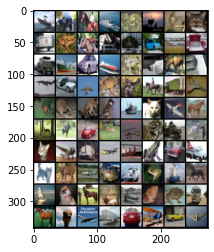

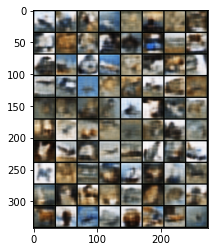

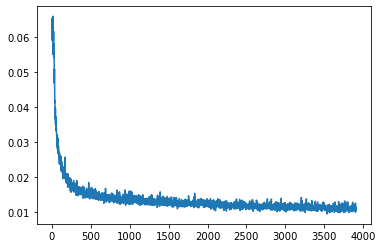

In [24]:
tr.train(20)

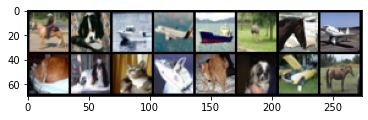

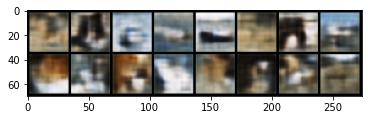

0.011047139


In [26]:
tr.test()

In [34]:
classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(24*4*4, 60),
                nn.BatchNorm1d(60),
                nn.ReLU(),
                nn.Linear(60, 60),
                nn.BatchNorm1d(60),
                nn.ReLU(),
                nn.Linear(60, 10)
                )
net_class = classifier.cuda()

In [35]:
tr2 = trainer2(net, net_class, trainloader, testloader)

loss =  1.4521152
loss =  1.291046
loss =  1.2261966
loss =  1.1813323
loss =  1.1508949
loss =  1.1201289
loss =  1.0964849
loss =  1.0767483
loss =  1.0556518
loss =  1.0407877
loss =  1.0246698
loss =  1.0103962
loss =  0.9994173
loss =  0.98741347
loss =  0.973112
loss =  0.9687493
loss =  0.95416665
loss =  0.94747597
loss =  0.94126856
loss =  0.93470216
loss =  0.926247
loss =  0.92030853
loss =  0.91108346
loss =  0.9032701
loss =  0.9055441
loss =  0.8981936
loss =  0.8937008
loss =  0.88383675
loss =  0.88087845
loss =  0.87339896
loss =  0.87306243
loss =  0.8687471
loss =  0.8614318
loss =  0.8586103
loss =  0.8574589
loss =  0.8529288
loss =  0.8500558
loss =  0.8446638
loss =  0.84233415
loss =  0.83660793
loss =  0.830954
loss =  0.8287981
loss =  0.8268689
loss =  0.8231938
loss =  0.8256023
loss =  0.82120967
loss =  0.8182824
loss =  0.8099434
loss =  0.81052023
loss =  0.8060133
loss =  0.8068384
loss =  0.8055008
loss =  0.7993439
loss =  0.7996751
loss =  0.7947236

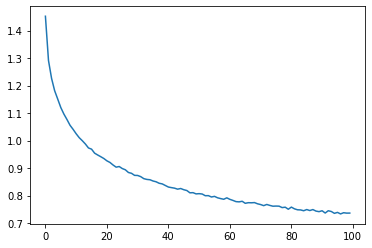

In [36]:
tr2.train(100)

In [37]:
tr2.test()

true lab =  tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
predicted lab =  tensor([3, 1, 8, 4, 2, 6, 5, 3, 3, 1, 0, 9, 5, 5, 9, 8, 5, 4, 8, 6, 3, 0, 2, 7,
        4, 4, 4, 7, 9, 6, 6, 2, 4, 5, 9, 6, 4, 9, 9, 5, 0, 6, 5, 6, 9, 1, 5, 7,
        4, 6, 9, 4, 6, 2, 8, 0, 5, 1, 3, 4, 7, 7, 1, 3, 5, 2, 9, 2, 2, 9, 6, 5,
        8, 8, 0, 5, 9, 3, 3, 8, 8, 7, 1, 5, 2, 7, 2, 8, 8, 9, 0, 4, 8, 6, 4, 6,
        6, 2, 7, 3, 4, 4, 5, 6, 1, 1, 0, 6, 8, 7, 7, 0, 6, 5, 9, 3, 0, 7, 3, 3,
        0, 4, 1, 2, 9, 2, 8, 3], device='cuda:0')
true lab =  tensor([5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 

true lab =  tensor([3, 8, 9, 5, 8, 9, 8, 9, 1, 6, 5, 9, 4, 4, 8, 0, 7, 2, 9, 7, 4, 1, 6, 4,
        4, 9, 1, 2, 5, 6, 0, 8, 6, 1, 9, 4, 5, 9, 5, 0, 7, 2, 0, 0, 4, 2, 6, 6,
        5, 5, 2, 8, 1, 7, 3, 1, 4, 5, 6, 5, 1, 4, 7, 0, 9, 4, 3, 8, 2, 8, 4, 7,
        2, 3, 1, 5, 2, 9, 8, 9, 7, 9, 5, 1, 4, 0, 8, 2, 3, 8, 9, 1, 1, 3, 2, 4,
        9, 3, 1, 7, 4, 6, 2, 8, 9, 5, 3, 9, 5, 5, 6, 7, 2, 4, 6, 3, 1, 0, 7, 2,
        5, 4, 7, 6, 1, 1, 9, 8], device='cuda:0')
predicted lab =  tensor([5, 8, 8, 5, 5, 7, 0, 8, 1, 6, 2, 1, 6, 4, 2, 0, 3, 3, 9, 7, 2, 1, 4, 4,
        8, 2, 5, 2, 4, 6, 0, 8, 4, 1, 9, 0, 5, 9, 3, 0, 7, 3, 0, 2, 7, 4, 4, 6,
        3, 2, 5, 8, 0, 2, 5, 0, 7, 4, 6, 3, 1, 7, 2, 8, 2, 4, 4, 8, 4, 8, 6, 7,
        4, 4, 9, 3, 7, 8, 8, 9, 7, 9, 5, 8, 4, 0, 8, 2, 5, 8, 9, 1, 9, 7, 0, 4,
        1, 4, 1, 4, 6, 6, 0, 4, 9, 5, 7, 8, 2, 6, 6, 4, 2, 3, 6, 3, 1, 0, 0, 0,
        3, 4, 2, 7, 1, 9, 7, 1], device='cuda:0')
true lab =  tensor([1, 0, 1, 3, 1, 1, 1, 7, 3, 9, 6, 8, 4, 6, 8, 4, 9, 

true lab =  tensor([9, 9, 0, 6, 6, 8, 1, 1, 7, 4, 4, 2, 3, 6, 9, 6, 2, 4, 1, 8, 2, 3, 1, 6,
        8, 6, 8, 5, 9, 0, 1, 0, 2, 9, 2, 9, 0, 9, 7, 8, 5, 0, 6, 6, 8, 1, 6, 5,
        8, 7, 9, 2, 1, 6, 7, 5, 6, 3, 0, 9, 8, 9, 5, 9, 9, 9, 3, 6, 4, 4, 8, 8,
        1, 7, 3, 0, 6, 2, 4, 8, 2, 2, 9, 2, 2, 9, 7, 4, 1, 9, 1, 4, 3, 5, 3, 8,
        9, 3, 6, 2, 0, 8, 9, 0, 5, 1, 5, 8, 2, 1, 2, 3, 2, 4, 8, 4, 0, 6, 4, 2,
        9, 8, 4, 7, 6, 2, 4, 7], device='cuda:0')
predicted lab =  tensor([0, 1, 9, 6, 6, 8, 8, 1, 5, 3, 3, 2, 3, 6, 5, 9, 2, 4, 9, 8, 3, 4, 1, 6,
        8, 6, 0, 5, 3, 0, 1, 0, 2, 9, 4, 9, 0, 9, 7, 0, 3, 0, 5, 6, 8, 1, 6, 7,
        8, 4, 6, 2, 1, 6, 4, 5, 6, 5, 2, 0, 8, 9, 7, 3, 0, 8, 5, 5, 6, 4, 8, 8,
        1, 7, 3, 0, 6, 3, 7, 8, 9, 2, 3, 6, 5, 9, 7, 2, 9, 5, 9, 3, 6, 0, 5, 8,
        3, 9, 5, 5, 8, 5, 8, 6, 5, 1, 9, 0, 3, 1, 8, 0, 3, 4, 8, 4, 9, 6, 6, 4,
        8, 8, 3, 9, 4, 2, 4, 5], device='cuda:0')
true lab =  tensor([7, 6, 4, 2, 2, 3, 2, 4, 9, 0, 0, 9, 6, 5, 8, 5, 2, 

true lab =  tensor([3, 8, 8, 0, 6, 7, 7, 6, 7, 2, 3, 2, 2, 6, 2, 7, 4, 0, 3, 6, 2, 6, 3, 3,
        0, 9, 5, 1, 1, 5, 3, 6, 4, 3, 4, 1, 0, 4, 5, 5, 2, 8, 9, 4, 3, 1, 8, 0,
        1, 3, 3, 4, 4, 2, 9, 7, 6, 8, 1, 8, 9, 1, 3, 1, 7, 3, 0, 0, 2, 8, 3, 9,
        2, 7, 2, 6, 0, 1, 6, 1, 6, 7, 5, 5, 2, 5, 9, 4, 0, 2, 3, 4, 9, 4, 1, 0,
        0, 2, 3, 8, 9, 2, 8, 9, 5, 7, 9, 1, 4, 6, 2, 8, 4, 4, 8, 9, 3, 1, 1, 6,
        5, 8, 4, 6, 4, 5, 2, 6], device='cuda:0')
predicted lab =  tensor([7, 8, 8, 8, 6, 7, 7, 6, 7, 2, 5, 4, 4, 5, 2, 5, 3, 5, 5, 2, 2, 6, 3, 2,
        0, 9, 9, 1, 1, 5, 3, 0, 4, 3, 2, 1, 3, 4, 4, 5, 2, 8, 9, 4, 5, 1, 8, 9,
        1, 3, 5, 4, 7, 6, 9, 1, 2, 2, 1, 8, 9, 9, 3, 9, 6, 3, 0, 0, 2, 1, 3, 4,
        2, 7, 7, 6, 0, 1, 3, 1, 6, 4, 5, 5, 6, 5, 9, 2, 8, 1, 6, 0, 9, 7, 1, 0,
        6, 4, 4, 8, 9, 2, 8, 9, 3, 7, 6, 1, 4, 2, 2, 8, 2, 5, 8, 9, 3, 1, 8, 6,
        2, 8, 4, 6, 6, 5, 4, 4], device='cuda:0')
true lab =  tensor([4, 2, 3, 1, 3, 6, 8, 5, 2, 2, 7, 1, 6, 2, 5, 9, 2, 

predicted lab =  tensor([1, 9, 3, 4, 5, 1, 8, 6, 3, 8, 6, 5, 1, 3, 4, 6, 7, 3, 8, 1, 6, 7, 4, 0,
        3, 6, 1, 7, 5, 7, 1, 2, 9, 0, 9, 0, 6, 1, 6, 2, 3, 3, 6, 9, 8, 7, 7, 4,
        7, 3, 7, 8, 6, 9, 9, 9, 8, 6, 4, 5, 8, 5, 4, 8, 9, 4, 0, 9, 3, 5, 6, 8,
        2, 0, 4, 0, 8, 8, 7, 3, 4, 0, 1, 5, 3, 3, 9, 8, 0, 5, 2, 9, 6, 5, 7, 1,
        6, 2, 4, 9, 9, 7, 1, 7, 0, 1, 2, 1, 3, 5, 8, 4, 0, 3, 8, 9, 2, 7, 8, 1,
        7, 6, 2, 6, 5, 8, 2, 1], device='cuda:0')
true lab =  tensor([3, 8, 9, 9, 0, 8, 8, 7, 9, 2, 9, 1, 3, 6, 7, 6, 0, 8, 6, 2, 4, 2, 3, 5,
        5, 4, 1, 6, 7, 1, 6, 1, 7, 1, 6, 2, 3, 0, 4, 2, 9, 7, 5, 5, 6, 0, 8, 8,
        1, 1, 3, 5, 6, 5, 3, 8, 7, 5, 0, 7, 7, 5, 7, 1, 9, 9, 1, 9, 9, 3, 5, 5,
        3, 0, 3, 0, 6, 6, 5, 6, 8, 9, 4, 5, 1, 1, 2, 7, 9, 0, 1, 2, 5, 4, 4, 7,
        4, 8, 3, 3, 5, 3, 5, 7, 0, 1, 2, 9, 8, 1, 7, 3, 5, 9, 1, 9, 1, 1, 3, 6,
        7, 4, 8, 3, 5, 6, 7, 0], device='cuda:0')
predicted lab =  tensor([5, 5, 9, 1, 8, 8, 5, 6, 9, 2, 2, 1, 5, 6, 4, 4

true lab =  tensor([4, 9, 5, 6, 6, 3, 0, 5, 2, 6, 3, 3, 8, 0, 8, 5, 4, 2, 9, 5, 0, 5, 4, 8,
        2, 7, 6, 5, 7, 8, 2, 0, 1, 8, 2, 4, 8, 4, 3, 0, 4, 0, 1, 9, 3, 0, 3, 6,
        5, 5, 2, 8, 5, 0, 8, 7, 5, 2, 4, 3, 7, 0, 2, 3, 1, 0, 0, 2, 1, 2, 1, 4,
        6, 7, 1, 0, 5, 2, 5, 9, 2, 5, 6, 7, 1, 9, 3, 6, 1, 0, 2, 9, 4, 2, 9, 3,
        8, 2, 9, 8, 5, 1, 0, 1, 5, 2, 5, 6, 8, 8, 3, 5, 0, 4, 1, 3, 7, 0, 3, 3,
        9, 2, 3, 9, 9, 8, 5, 9], device='cuda:0')
predicted lab =  tensor([4, 4, 5, 6, 3, 5, 9, 5, 2, 6, 3, 3, 4, 0, 8, 3, 4, 2, 9, 5, 0, 5, 7, 8,
        7, 7, 8, 7, 7, 8, 2, 0, 1, 8, 2, 4, 8, 4, 2, 8, 4, 0, 7, 9, 4, 4, 4, 6,
        3, 0, 7, 0, 2, 8, 9, 2, 3, 5, 4, 6, 4, 4, 5, 5, 1, 0, 0, 2, 8, 6, 9, 4,
        6, 4, 1, 1, 5, 6, 3, 9, 5, 5, 6, 7, 1, 1, 7, 3, 1, 0, 2, 8, 2, 7, 9, 7,
        1, 4, 1, 8, 7, 1, 2, 1, 5, 3, 2, 2, 4, 8, 3, 7, 0, 2, 1, 3, 7, 2, 3, 5,
        0, 7, 0, 9, 9, 8, 5, 9], device='cuda:0')
true lab =  tensor([7, 2, 0, 9, 4, 7, 1, 7, 6, 4, 4, 8, 9, 0, 7, 1, 2, 

true lab =  tensor([5, 1, 9, 2, 4, 1, 3, 7, 8, 2, 0, 9, 6, 6, 0, 6, 5, 8, 2, 7, 4, 0, 2, 7,
        7, 8, 8, 7, 0, 4, 9, 1, 4, 4, 3, 5, 4, 6, 2, 3, 1, 0, 3, 3, 3, 6, 3, 1,
        2, 8, 9, 7, 9, 3, 8, 7, 3, 1, 7, 7, 3, 2, 2, 8, 9, 5, 9, 2, 1, 7, 4, 4,
        0, 5, 7, 1, 5, 4, 0, 8, 4, 9, 8, 7, 8, 4, 2, 3, 4, 0, 5, 4, 1, 8, 2, 5,
        4, 5, 2, 5, 3, 7, 9, 7, 1, 4, 1, 3, 1, 4, 5, 5, 1, 7, 1, 3, 0, 1, 2, 5,
        7, 0, 6, 3, 5, 7, 5, 5], device='cuda:0')
predicted lab =  tensor([3, 1, 0, 4, 6, 3, 3, 7, 8, 0, 8, 9, 6, 6, 8, 2, 5, 8, 1, 0, 2, 0, 2, 9,
        7, 8, 8, 2, 0, 2, 8, 1, 2, 8, 3, 7, 3, 2, 2, 3, 1, 0, 3, 8, 6, 2, 5, 1,
        2, 8, 1, 0, 9, 3, 8, 4, 3, 1, 9, 7, 6, 3, 6, 0, 9, 6, 9, 2, 3, 7, 1, 0,
        0, 3, 2, 1, 5, 4, 2, 9, 4, 9, 8, 7, 8, 2, 3, 3, 4, 8, 3, 4, 1, 8, 5, 0,
        4, 1, 4, 4, 4, 7, 9, 7, 9, 0, 1, 1, 1, 4, 3, 5, 9, 7, 9, 4, 1, 8, 4, 7,
        7, 0, 5, 3, 3, 7, 6, 5], device='cuda:0')
true lab =  tensor([8, 9, 4, 6, 3, 6, 6, 8, 2, 6, 4, 8, 4, 1, 3, 1, 2, 

true lab =  tensor([7, 4, 4, 9, 3, 8, 3, 7, 7, 8, 5, 3, 9, 1, 6, 7, 3, 3, 3, 8, 5, 6, 1, 3,
        7, 9, 6, 1, 6, 4, 9, 0, 5, 7, 4, 9, 1, 0, 0, 2, 7, 8, 3, 2, 7, 6, 1, 6,
        6, 4, 4, 2, 1, 8, 4, 4, 7, 8, 5, 8, 9, 4, 3, 2, 2, 9, 3, 0, 1, 1, 1, 1,
        6, 8, 7, 1, 3, 0, 4, 5, 0, 3, 0, 6, 2, 0, 9, 8, 6, 8, 5, 8, 2, 9, 6, 0,
        6, 1, 8, 7, 3, 2, 2, 6, 5, 6, 9, 2, 5, 4, 9, 8, 5, 3, 9, 3, 5, 7, 1, 8,
        5, 8, 6, 2, 5, 1, 3, 0], device='cuda:0')
predicted lab =  tensor([4, 4, 6, 8, 5, 8, 7, 7, 7, 8, 5, 4, 4, 4, 6, 3, 5, 7, 3, 8, 5, 5, 9, 5,
        5, 9, 7, 1, 6, 0, 7, 3, 5, 7, 2, 9, 1, 8, 0, 2, 7, 1, 7, 2, 4, 5, 1, 6,
        6, 4, 6, 0, 2, 9, 4, 2, 9, 8, 2, 8, 1, 3, 3, 2, 5, 1, 4, 0, 1, 1, 1, 1,
        6, 8, 4, 1, 3, 2, 4, 5, 0, 5, 0, 6, 9, 2, 9, 8, 3, 8, 3, 8, 4, 9, 6, 0,
        4, 9, 0, 3, 6, 3, 2, 6, 2, 2, 9, 4, 3, 7, 9, 8, 3, 3, 9, 1, 5, 4, 4, 8,
        5, 0, 3, 2, 3, 8, 5, 0], device='cuda:0')
true lab =  tensor([4, 1, 9, 5, 4, 9, 2, 1, 4, 2, 5, 9, 8, 7, 2, 1, 6, 

true lab =  tensor([8, 1, 0, 2, 8, 5, 6, 7, 0, 1, 4, 8, 4, 4, 6, 6, 5, 8, 1, 8, 4, 6, 5, 9,
        2, 2, 1, 4, 9, 1, 6, 7, 2, 0, 1, 7, 6, 5, 2, 2, 5, 6, 0, 9, 0, 1, 5, 3,
        3, 5, 8, 7, 5, 6, 5, 8, 0, 5, 9, 4, 6, 5, 1, 1, 0, 3, 3, 9, 4, 8, 1, 7,
        7, 9, 9, 4, 3, 6, 3, 2, 8, 2, 7, 6, 7, 0, 2, 1, 2, 9, 4, 6, 9, 6, 1, 0,
        1, 8, 7, 0, 0, 4, 7, 4, 2, 6, 9, 5, 9, 0, 7, 4, 5, 8, 1, 4, 7, 9, 9, 8,
        8, 6, 3, 7, 0, 8, 9, 6], device='cuda:0')
predicted lab =  tensor([8, 5, 8, 4, 0, 3, 7, 7, 0, 6, 4, 8, 3, 4, 6, 6, 7, 8, 1, 8, 4, 6, 3, 9,
        4, 2, 1, 2, 9, 9, 6, 7, 2, 0, 1, 7, 4, 5, 2, 2, 1, 3, 0, 9, 8, 1, 6, 2,
        2, 3, 8, 7, 8, 2, 3, 8, 8, 5, 9, 6, 3, 5, 0, 1, 0, 5, 3, 9, 2, 8, 0, 7,
        4, 1, 9, 7, 5, 4, 4, 5, 8, 2, 9, 6, 6, 2, 3, 1, 5, 9, 2, 2, 9, 6, 6, 0,
        0, 8, 7, 7, 0, 2, 7, 0, 5, 6, 8, 7, 9, 0, 5, 4, 5, 8, 9, 2, 4, 6, 9, 8,
        1, 3, 7, 7, 0, 8, 9, 0], device='cuda:0')
true lab =  tensor([2, 4, 6, 2, 9, 7, 4, 6, 8, 5, 6, 1, 3, 5, 9, 9, 1, 

Автокодировщик на линейных слоях

In [66]:
class AE_lin(nn.Module):
    def __init__(self, input_size, hidden_dim = 150, latent_size = 150, layers = 3):
        super(AE_lin, self).__init__()

        encod = [nn.Flatten(), nn.Linear(input_size**2*3, hidden_dim), nn.ReLU()]
        
        for i in range(layers-1):
            encod.append(nn.Linear(hidden_dim, hidden_dim))
            encod.append(nn.BatchNorm1d(hidden_dim))
            encod.append(nn.ReLU())
            
        encod.append(nn.Linear(hidden_dim, latent_size))
        self.encoder = nn.Sequential(*encod)
        
        decod = [nn.Linear(latent_size, hidden_dim)]

        for i in range(layers-1):
            decod.append(nn.Linear(hidden_dim, hidden_dim))
            decod.append(nn.BatchNorm1d(hidden_dim))
            decod.append(nn.ReLU())
            
        decod.append(nn.Linear(hidden_dim, input_size**2*3))
        decod.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decod)
        
    def forward(self, x):
        b_size = x.size(0)
        c_size = x.size(1)
        im_size = x.size(2)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape([b_size, c_size, im_size, im_size])
        return [encoded, decoded]

In [67]:
net = AE_lin(input_size=32, layers=3).cuda()

In [68]:
tr = trainer(net, trainloader, testloader)

loss =  0.02842413
loss =  0.022860678
loss =  0.022062121
loss =  0.020962052
loss =  0.02038092
loss =  0.01990581
loss =  0.019351318
loss =  0.018979734
loss =  0.01885863
loss =  0.01867547
loss =  0.018381286
loss =  0.01800434
loss =  0.017736161
loss =  0.017564803
loss =  0.017457955
loss =  0.017401055
loss =  0.017152186
loss =  0.017017381
loss =  0.016866272
loss =  0.016642485
loss =  0.016497286
loss =  0.016366158
loss =  0.016297838
loss =  0.016250437
loss =  0.016262487
loss =  0.01628237
loss =  0.016194696
loss =  0.016107056
loss =  0.015758568
loss =  0.015689315
loss =  0.015601407
loss =  0.015569799
loss =  0.015569392
loss =  0.015574909
loss =  0.015545547
loss =  0.01551844
loss =  0.015520573
loss =  0.015548165
loss =  0.015489034
loss =  0.015480447
loss =  0.015491761
loss =  0.015486705
loss =  0.015452929
loss =  0.015434738
loss =  0.015512754
loss =  0.015435731
loss =  0.015469402
loss =  0.015408591
loss =  0.015443834
loss =  0.015456603


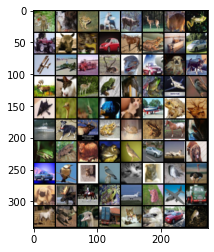

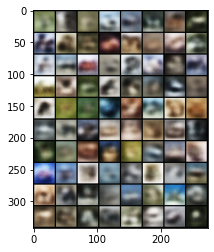

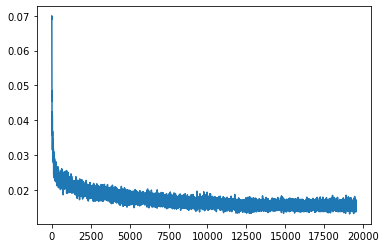

In [69]:
tr.train(50)

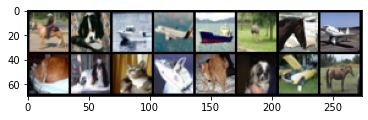

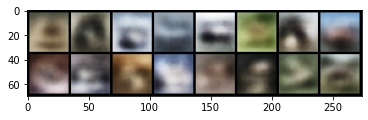

0.015787227


In [70]:
tr.test()